In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CMSC828C/Project 2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CMSC828C/Project 2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = False
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


In [ ]:
# parameters
NUM_TRAIN = 50000
NUM_VAL = 10000
NUM_TEST = 10000
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
N_EPOCHS = 15

N_CLASSES = 10

In [ ]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
# define transforms
transform = T.Compose([T.Resize((32, 32)),
                        T.ToTensor()])

mnist_train = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=BATCH_SIZE, sampler = sampler.SubsetRandomSampler(range(NUM_TRAIN)))

mnist_val = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_val = DataLoader(mnist_train, batch_size=BATCH_SIZE, sampler = sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

mnist_test = dset.MNIST('./Datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test,  batch_size=BATCH_SIZE)

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [ ]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc*100

In [ ]:
import torch.nn.functional as F



def train_loop(model, optimizer, epochs=1):
    """
    Train a model on MNIST using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_losses = []
    val_accuracies = []
    for e in range(epochs):
        print('------ Epoch ' + str(e) +  ' -------')
        running_train_loss = 0
        running_val_acc = 0
        len_val_acc = 0
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            running_train_loss += loss.item()
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                val_acc = check_accuracy(loader_val, model)
                running_val_acc += val_acc
                len_val_acc += 1
                print()
        running_train_loss = running_train_loss/len(loader_train.dataset)
        running_val_acc = running_val_acc/len_val_acc            
        train_losses.append(running_train_loss)
        val_accuracies.append(running_val_acc)
    return train_losses, val_accuracies  

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

learning_rate = 1e-3
num_epochs = 15

# ------------ LeNet 5 ---------------
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=1), # C1
    nn.Tanh(),
    nn.AvgPool2d(2), # S2
    nn.Conv2d(6, 16, kernel_size=5, stride = 1),  # C3
    nn.Tanh(),    
    nn.AvgPool2d(2), # S4
    nn.Conv2d(16, 120, kernel_size=5), # C5
    nn.Tanh(),
    nn.Flatten(), 
    nn.Linear(120, 84), # F6
    nn.Tanh(),
    nn.Linear(84, N_CLASSES), # OUTPUT
    nn.Softmax(1) 
)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_accuracies = train_loop(model, optimizer, epochs=N_EPOCHS)

------ Epoch 0 -------
Iteration 0, loss = 2.3043
Checking accuracy on validation set
Got 983 / 10000 correct (9.83)

Iteration 100, loss = 1.5905
Checking accuracy on validation set
Got 8790 / 10000 correct (87.90)

Iteration 200, loss = 1.6069
Checking accuracy on validation set
Got 9176 / 10000 correct (91.76)

Iteration 300, loss = 1.5389
Checking accuracy on validation set
Got 9247 / 10000 correct (92.47)

Iteration 400, loss = 1.5831
Checking accuracy on validation set
Got 9333 / 10000 correct (93.33)

Iteration 500, loss = 1.5530
Checking accuracy on validation set
Got 9418 / 10000 correct (94.18)

Iteration 600, loss = 1.5156
Checking accuracy on validation set
Got 9445 / 10000 correct (94.45)

Iteration 700, loss = 1.5357
Checking accuracy on validation set
Got 9490 / 10000 correct (94.90)

------ Epoch 1 -------
Iteration 0, loss = 1.5067
Checking accuracy on validation set
Got 9538 / 10000 correct (95.38)

Iteration 100, loss = 1.5522
Checking accuracy on validation set
Got 

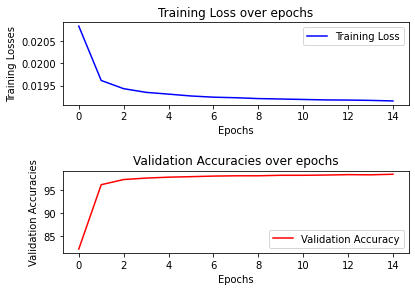

Final Training Loss: 0.019155426559845607
Final Validation Accuracy: 98.47 %


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(2,1,1)
plt.plot(np.arange(N_EPOCHS), train_losses, 'b', label='Training Loss')
plt.title('Training Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Losses')
plt.legend()


plt.subplot(2,1,2)
plt.plot(np.arange(N_EPOCHS), val_accuracies, 'r', label='Validation Accuracy')
plt.title('Validation Accuracies over epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracies')
plt.legend()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.8)
plt.show()

print('Final Training Loss: ' + str(train_losses[-1]))
print('Final Validation Accuracy: ' + str(val_accuracies[-1]) +' %')

In [ ]:
best_model = model
test_acc = check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got 9843 / 10000 correct (98.43)
